In [1]:
# %%
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting, image

In [2]:
def mosaic(volume, cmap='gray'):
    # Plot each axial slice in a big figure
    fig, axes = plt.subplots(6, 8, figsize=(16, 12))
    for i in range(volume.shape[2]):
        ax = axes[i // 8, i % 8]
        ax.imshow(volume[:, :, i].T, origin='lower', cmap=cmap)
        ax.axis('off')
        ax.set_title(f"z={i}")

    plt.tight_layout()
    plt.show()

In [3]:
roi_dir = '/Users/hugofluhr/phd_local/data/LearningHabits/dev_sample/masks/MNI152NLin2009cAsym'

def load_rois(roi_dir, ref_img = None, bool_data = False):
    files = [f for f in os.listdir(roi_dir) if f.endswith('.nii')]
    roi_names = [f.split('_')[0] for f in files]

    rois = {n: image.load_img(os.path.join(roi_dir, f)) for n, f in zip(roi_names, files)}

    if ref_img is not None:
        rois = {n: image.resample_to_img(img, ref_img, force_resample=True, copy_header=True)
            for n, img in rois.items()}

    if bool_data:
        rois = {n: np.squeeze(img.get_fdata() > 0)
            for n, img in rois.items()}

    return rois

# With SDC

In [4]:
mask_dir = os.path.expanduser('~/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57')  # adjust if needed

In [5]:
# === Collect mask files ===
mask_files = sorted([os.path.join(mask_dir, f)
                     for f in os.listdir(mask_dir)
                     if f.endswith('.nii') or f.endswith('.nii.gz')])

print(f"Found {len(mask_files)} masks.")
mask_files[:5]
learning_masks = [m for m in mask_files if 'learning' in m]
test_masks = [m for m in mask_files if 'test' in m]

Found 120 masks.


## Learning Masks

In [51]:
data_learning = np.stack([image.load_img(f).get_fdata().astype(bool) for f in learning_masks], axis=-1)
print(f"Mask shape: {data_learning.shape[:-1]}, N subjects: {data_learning.shape[-1]}")

Mask shape: (53, 65, 48), N subjects: 60


In [52]:
# Already remove sub-54 because it's terrible
data_learning = np.delete(data_learning, 42, axis=-1)

In [53]:
## === Compute voxelwise coverage ===
coverage = data_learning.mean(axis=-1)
intersection = coverage == 1

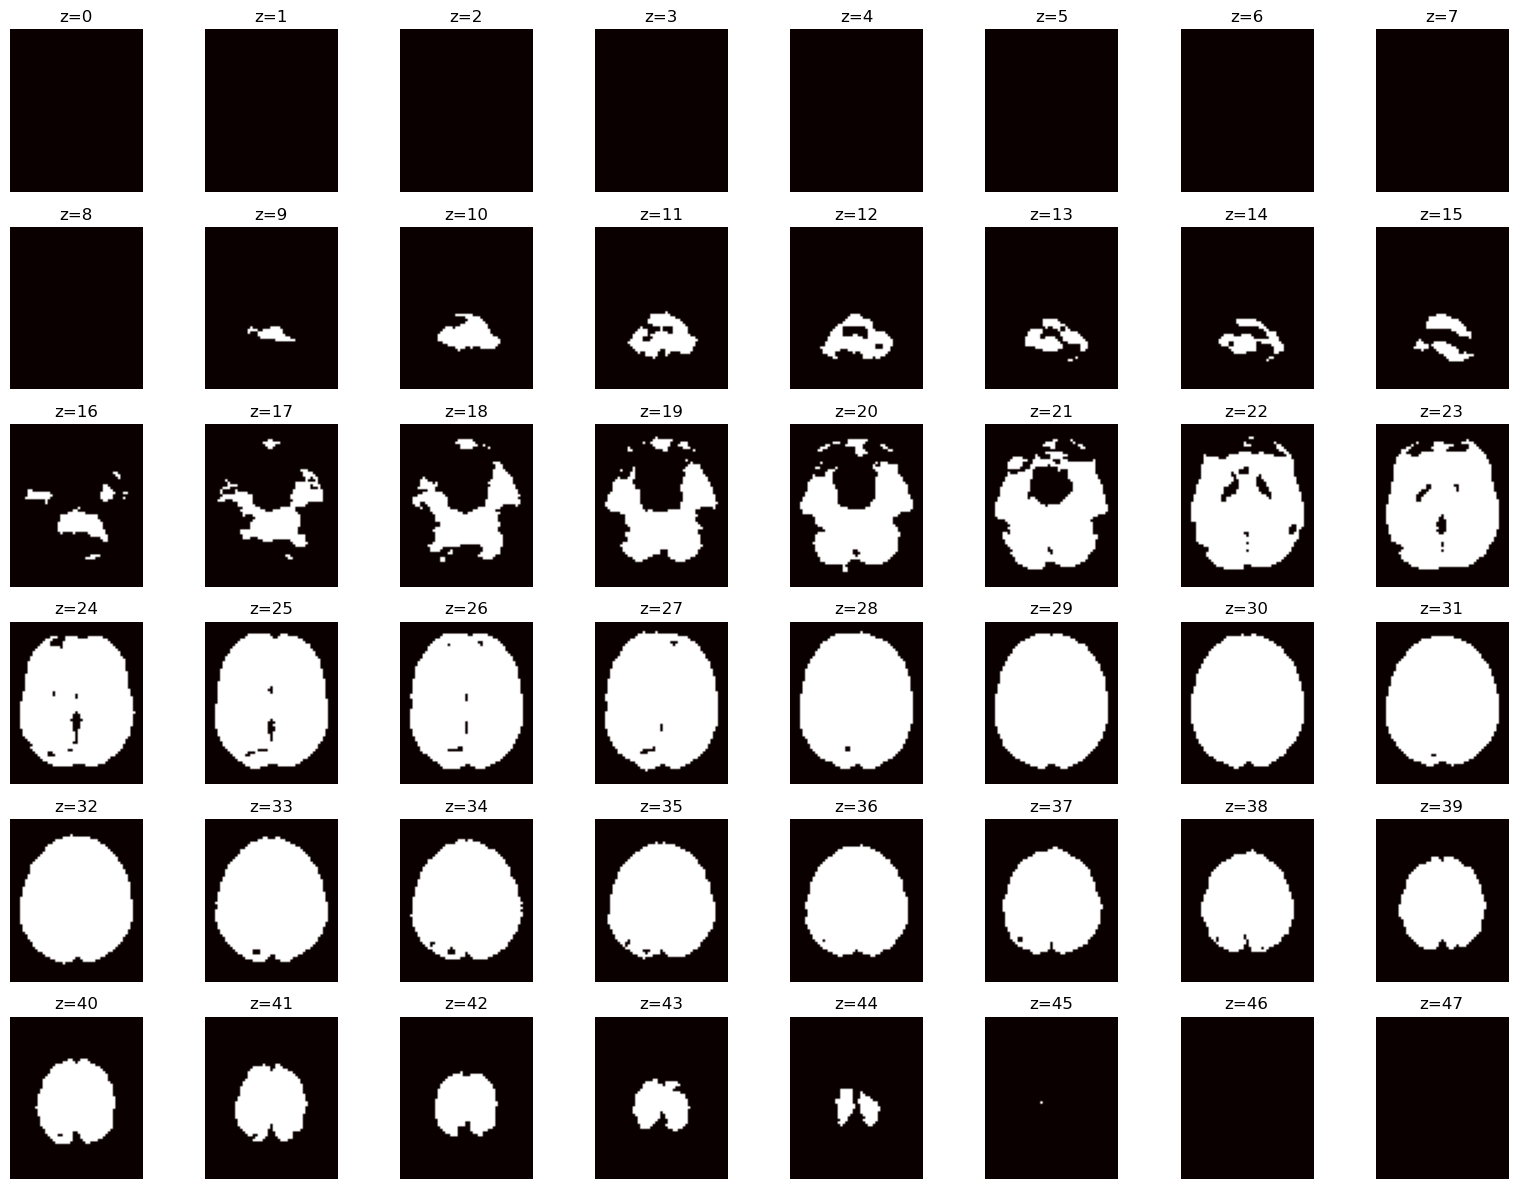

In [54]:
mosaic(intersection.astype(int), cmap='hot')

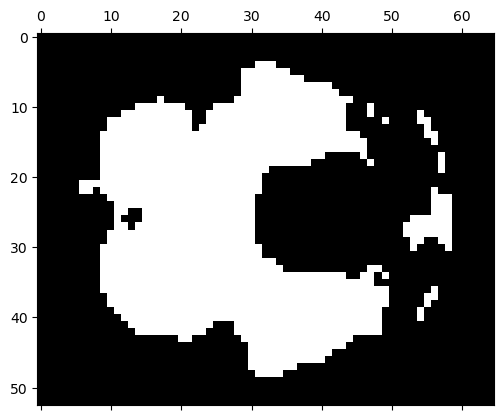

In [55]:
plt.matshow(intersection[...,20], cmap='grey')

In [11]:
# problematic locations:
#x, y, z = 22, 13, 25
#x, y, z = 32, 56, 27
x, y, z = 20, 50, 20
intersection[x,y,z]

np.False_

In [12]:
np.where(data_learning[x,y,z,:]==0)[0]

array([14, 31, 55])

In [13]:
tagged_learning = [7, 14, 22, 31, 55]
print('tagged masks: ')
for i in tagged_learning:
    print(learning_masks[i])

tagged masks: 
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-09_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-18_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-27_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-38_learning_mask.nii
/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/glm2_combined_2025-10-7-03-57/sub-69_learning_mask.nii


In [14]:
new_learning_mask = np.delete(data_learning, tagged_learning, axis=-1).mean(axis=-1) == 1.

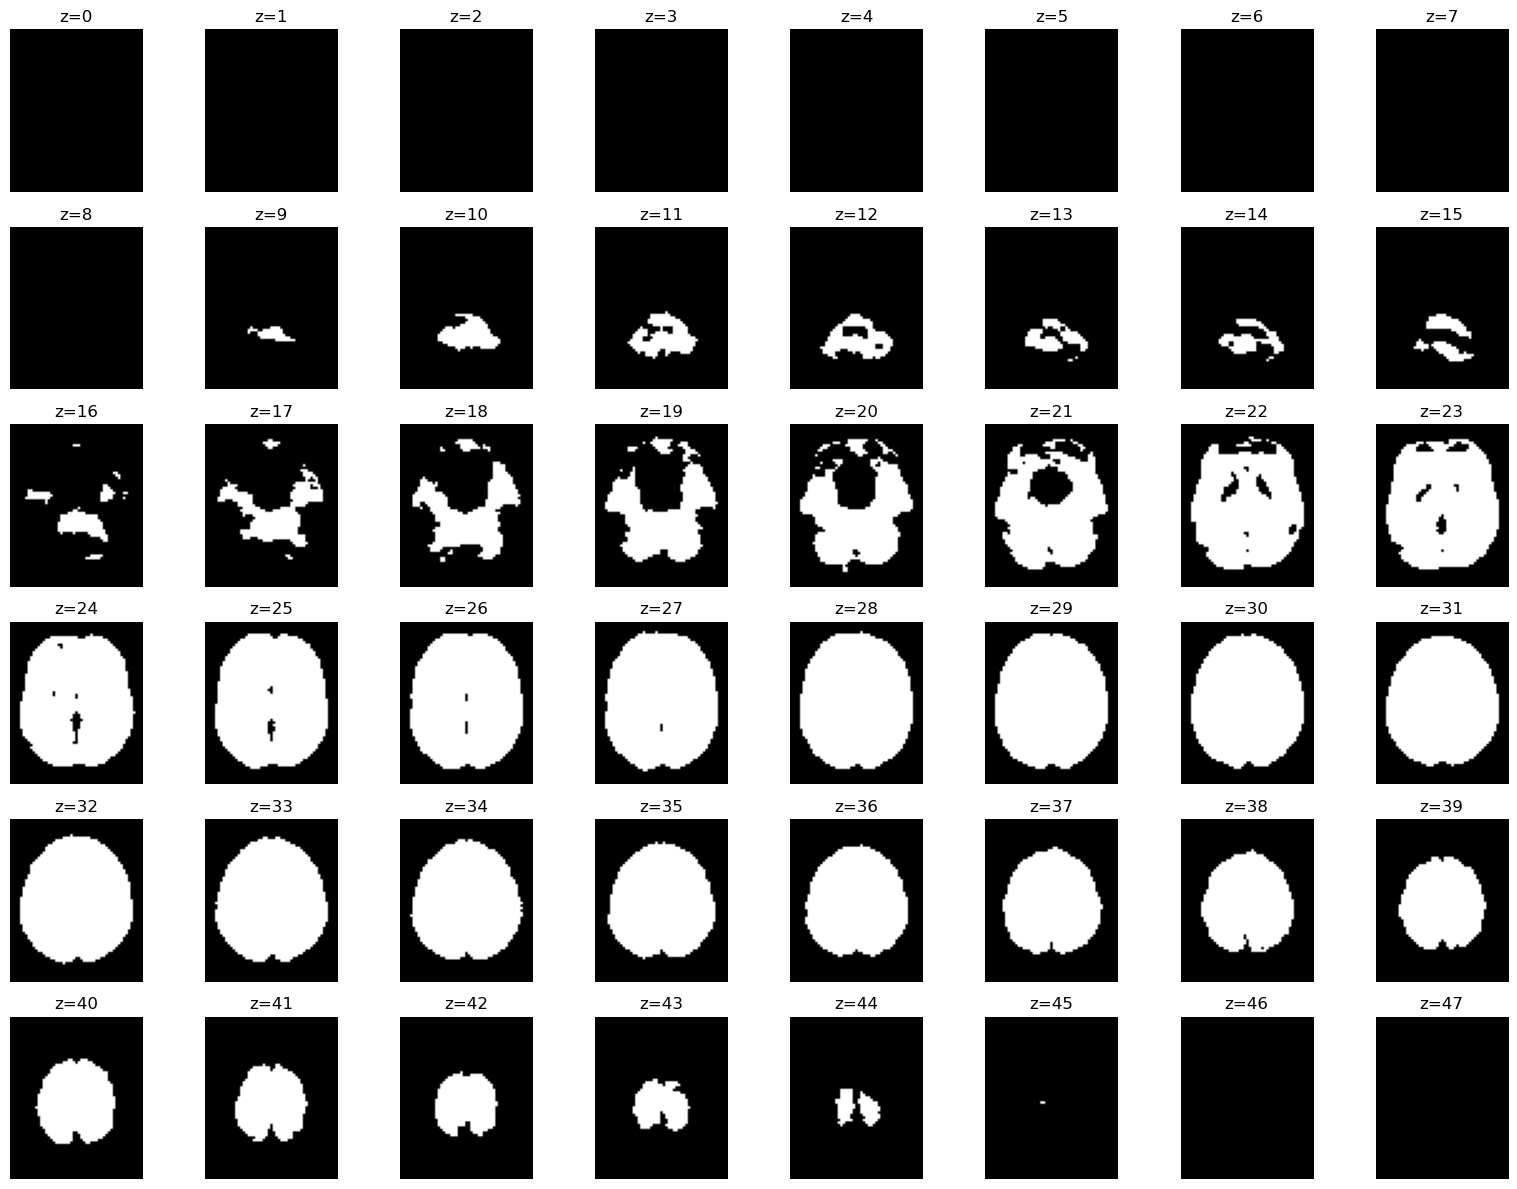

In [15]:
mosaic(new_learning_mask)

### Checking our ROIs

In [16]:
ROIs = load_rois(roi_dir, ref_img=learning_masks[0], bool_data=True)

In [39]:
n_subj * 0.95

57.0

In [46]:
lenient = coverage >= 0.9

for name, roi in ROIs.items():
    n_voxels = roi.sum()
    roi_coverage = (lenient*roi).sum()
    frac = (roi_coverage / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {roi_coverage:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum            70/   128 vox  ( 54.69%)
habit              604/   657 vox  ( 91.93%)
vmpfc              109/   119 vox  ( 91.60%)
parietal          2700/  2885 vox  ( 93.59%)
motor             5780/  6345 vox  ( 91.10%)


## Test

In [49]:
data_test = np.stack([image.load_img(f).get_fdata().astype(bool) for f in test_masks], axis=-1)
coverage_test = data_test.mean(axis=-1)
intersection_test = coverage_test == 1

In [50]:
lenient_test = coverage_test >= 0.9

for name, roi in ROIs.items():
    n_voxels = roi.sum()
    roi_coverage = (lenient_test*roi).sum()
    frac = (roi_coverage / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {roi_coverage:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum            80/   128 vox  ( 62.50%)
habit              619/   657 vox  ( 94.22%)
vmpfc              111/   119 vox  ( 93.28%)
parietal          2719/  2885 vox  ( 94.25%)
motor             5798/  6345 vox  ( 91.38%)


# With NO SDC

In [18]:
mask_dir = '/Users/hugofluhr/phd_local/data/LearningHabits/first_lvl_masks/noSDC'

In [19]:
# === Collect mask files ===
mask_files_noSDC = sorted([os.path.join(mask_dir, f)
                     for f in os.listdir(mask_dir)
                     if f.endswith('.nii') or f.endswith('.nii.gz')])

print(f"Found {len(mask_files_noSDC)} masks.")
mask_files_noSDC[:5]
learning_masks_noSDC = [m for m in mask_files_noSDC if 'learning' in m]
test_masks_noSDC = [m for m in mask_files_noSDC if 'test' in m]

Found 120 masks.


## Learning Masks

In [58]:
data_learning_noSDC = np.stack([image.load_img(f).get_fdata().astype(bool) for f in learning_masks_noSDC], axis=-1)
coverage_noSDC = data_learning_noSDC.mean(axis=-1)
intersection_noSDC = coverage_noSDC == 1

### Checking ROIs coverage

In [59]:
ROIs = load_rois(roi_dir, ref_img=learning_masks[0], bool_data=True)

lenient_noSDC = coverage_noSDC >= 0.95
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_noSDC*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum           113/   128 vox  ( 88.28%)
habit              651/   657 vox  ( 99.09%)
vmpfc              118/   119 vox  ( 99.16%)
parietal          2667/  2885 vox  ( 92.44%)
motor             5759/  6345 vox  ( 90.76%)


## Test Masks

In [60]:
data_test_noSDC = np.stack([image.load_img(f).get_fdata().astype(bool) for f in test_masks_noSDC], axis=-1)
coverage_test_noSDC = data_test_noSDC.mean(axis=-1)
intersection_test_noSDC = coverage_test_noSDC == 1

### Checking ROIs coverage

In [61]:
ROIs = load_rois(roi_dir, ref_img=test_masks[0], bool_data=True)

lenient_test_noSDC = coverage_test_noSDC >= 0.95
for name, roi in ROIs.items():
    n_voxels = roi.sum()
    coverage_roi = (lenient_test_noSDC*roi).sum()
    frac = (coverage_roi / n_voxels) if n_voxels else 0.0
    print(f"{name:<15s} {coverage_roi:6d}/{n_voxels:6d} vox  ({frac*100:6.2f}%)")

striatum           121/   128 vox  ( 94.53%)
habit              653/   657 vox  ( 99.39%)
vmpfc              119/   119 vox  (100.00%)
parietal          2674/  2885 vox  ( 92.69%)
motor             5752/  6345 vox  ( 90.65%)
